In [41]:
import json
import datetime
import numpy as np
import pandas as pd
import snowballstemmer
from bs4 import BeautifulSoup
import itertools

from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_error

import seaborn as sns
import  matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dataframe = pd.read_json("tj_site.json")
dataframe.index = range(dataframe.shape[0])

In [70]:
dataframe.head()

,article,comments,date,hits,rating,title,month,time,day,year,...,links_count,youtube_count,tweets_count,tags_count,p_count,text_sizes,text_sizes_mean,text_sizes_std,text_words_count,title_words_count
0,<article>\n<p>Казачьим обществом «ИРБИС» в Пет...,3,"18 ноября 2014, 20:28",301,7,Репротаж из православной парикмахерской Петерб...,11,1228,18,2014,...,1,0,0,5,1,[33],33.0,0.0,33,5
1,"<article>\n<a class=""link-widget"" href=""http:/...",0,"18 ноября 2014, 20:34",262,5,Whats App стал безопаснее на Android,11,1234,18,2014,...,1,1,0,15,2,"[0, 27]",13.5,13.5,27,3
2,"<article>\n<a class=""link-widget"" href=""http:/...",1,"18 ноября 2014, 22:39",99,4,Ловкие руки Марселя,11,1359,18,2014,...,-1,1,0,13,2,"[0, 37]",18.5,18.5,37,3
3,<article>\n<p>Чо как дела ребят</p>\n</article>,10,"19 ноября 2014, 16:06",291,-32,Оплатил 100 рублей,11,966,19,2014,...,0,0,0,4,1,[4],4.0,0.0,4,2
4,<article>\n<p>Лихачев няшка. Ваши мнения? </p>...,37,"19 ноября 2014, 16:09",846,29,Давайте здесь обсуждать Лихачева,11,969,19,2014,...,0,0,0,4,1,[4],4.0,0.0,4,4


In [3]:
def get_time(x):
    time = x.split()[-1]
    h, m = time.split(":")
    return int(h)*60 + int(m)

m_keys = {
    'января': 1,
    'февраля': 2,
    'марта': 3,
    'апреля': 4,
    'мая': 5,
    'июня': 6,
    'июля': 7,
    'августа': 8,
    'сентября': 9,
    'октября': 10,
    'ноября': 11,
    'декабря': 12,
}

In [4]:
dataframe['month'] = dataframe.date.apply(lambda x: m_keys[x.split()[1]])
dataframe['time'] = dataframe.date.apply(get_time)
dataframe['day'] = dataframe.date.apply(lambda x: int(x.split()[0]))
dataframe['year'] = dataframe.date.apply(lambda x: int(x.split()[2][:-1]))
dataframe["weekday"] = dataframe[["year", "month", "day"]].apply(lambda x: datetime.date(*x).weekday(), axis=1)

In [5]:
stemmer = snowballstemmer.RussianStemmer()
rus_chars = set([chr(i) for i in range(1072, 1104)])

def tokenize_sent(sent):
    sent = sent.lower()
    sent = "".join([i if i in rus_chars else " " for i in sent])
    words = stemmer.stemWords(sent.split())
    return words

In [6]:
def get_p_data(article):
    html = BeautifulSoup(article, "lxml")
    data = html.findAll("p")
    return [i.text for i in data]

def get_p_count(article):
    html = BeautifulSoup(article, "lxml")
    data = html.findAll("p")
    return len(data)

def get_p_sizes(article):
    html = BeautifulSoup(article, "lxml")
    data = html.findAll("p")
    return [len(preprocess_sent(i.text)) for i in data]

def get_tags_count(article):
    html = BeautifulSoup(article, "lxml")
    data = html.findAll()
    return len(data)

def mean_p(x):
    if not len(x):
        return -9999
    return np.mean(x)

def std_p(x):
    if not len(x):
        return -9999
    return np.std(x)

In [7]:
dataframe['p_list'] = dataframe.article.apply(get_p_data)
dataframe['text_chained'] = dataframe.p_list.apply(lambda x: "\n".join(x))

dataframe['p_list_tokenized'] = dataframe.p_list.apply(lambda x: [tokenize_sent(i) for i in x])
dataframe['p_list_tokenized_joined'] = dataframe.p_list_tokenized.apply(lambda x: list(itertools.chain(*x)))
dataframe['title_tokenized'] = dataframe.title.apply(tokenize_sent)

dataframe['images_count'] = dataframe.article.apply(lambda x: x.count("wrapper-image"))
dataframe['wide_labels_count'] = dataframe.article.apply(lambda x: x.count("wrapper-wide"))
dataframe['link_widget_count'] = dataframe.article.apply(lambda x: x.count("link-widget"))
dataframe['links_count'] = dataframe.article.apply(lambda x: x.count("a href")) - \
    (dataframe.images_count + dataframe.link_widget_count)
dataframe['youtube_count'] = dataframe.article.apply(lambda x: x.count("wrapper-video"))
dataframe['tweets_count'] = dataframe.article.apply(lambda x: x.count("wrapper-tweet"))
dataframe["tags_count"] = dataframe.article.apply(get_tags_count)
dataframe["p_count"] = dataframe.p_list.apply(len)
dataframe["text_sizes"] = dataframe.p_list_tokenized.apply(lambda x: [len(i) for i in x])
dataframe["text_sizes_mean"] = dataframe.text_sizes.apply(mean_p)
dataframe["text_sizes_std"] = dataframe.text_sizes.apply(std_p)
dataframe["text_words_count"] = dataframe.p_list_tokenized.apply(lambda x: len(list(itertools.chain(*x))))
dataframe["title_words_count"] = dataframe.title_tokenized.apply(lambda x: len(x))

In [8]:
count_vec = CountVectorizer(tokenizer = tokenize_sent, min_df=10, max_df=0.95)
text_count_vec = count_vec.fit_transform(dataframe.text_chained)
text_tfidf_vec = TfidfTransformer().fit_transform(text_count_vec).toarray()

lda_features = []
topic_counts = [10, 20, 50]
for topics in topic_counts:
    lda = LatentDirichletAllocation(topics, n_jobs=7, learning_method="batch")
    feats = lda.fit_transform(text_count_vec)
    lda_features.append(feats)

lda_features = np.concatenate(lda_features, axis=1)

In [10]:
w2v = Word2Vec(dataframe.p_list_tokenized_joined, size=300, workers=7, min_count=5)
w2v_dict = {key:w2v.wv.syn0[val.index] for key, val in w2v.wv.vocab.items()}

vectors = list(w2v_dict.values())
words = list(w2v_dict.keys())

In [12]:
from sklearn.cluster import KMeans

kmeans = []
clusters_counts = [10, 50, 100, 500, 1000]
for clusters in clusters_counts:
    kmeans.append(KMeans(clusters, precompute_distances=True, n_jobs=7).fit(vectors))

In [13]:
word_mappings = []
for kmean in kmeans:
    labels = kmean.labels_
    word_mappings.append(dict(zip(words, labels)))

In [14]:
words_set = set(words)

In [15]:
def get_mean_vec(sent):
    matrix = [w2v_dict[i] for i in sent if i in words_set]
    if not matrix:
        return np.full((300,), -9999)
    return np.mean(matrix, axis=0)

def get_centroids_vec(sent):
    words = [i for i in sent if i in words_set]
    if not words:
        return np.full((sum(clusters_counts),), -9999)
    result_total = np.asarray([])
    for cnt, mapper in zip(clusters_counts, word_mappings):
        result = np.zeros((cnt, ))
        for word in words:
            result[mapper[word]] += 1
        result_total = np.concatenate([result_total, result])
    return result_total

In [16]:
mean_texts = np.asarray([get_mean_vec(s) for s in dataframe.p_list_tokenized_joined.tolist()])
mean_titles = np.asarray([get_mean_vec(s) for s in dataframe.title_tokenized.tolist()])
clusters_texts = np.asarray([get_centroids_vec(s) for s in dataframe.p_list_tokenized_joined.tolist()])
clusters_titles = np.asarray([get_centroids_vec(s) for s in dataframe.title_tokenized.tolist()])

In [17]:
feats = ["time", "day", "weekday", "month",
         "images_count", "wide_labels_count",
         "link_widget_count", "links_count",
         "youtube_count", "tweets_count",
         "tags_count", "p_count", "text_sizes_mean",
         "text_sizes_std", "text_words_count",
         "title_words_count"]
X = dataframe[feats].as_matrix()

In [18]:
preprocessed_df = np.concatenate([X, lda_features, mean_texts, mean_titles, clusters_texts, clusters_titles], axis=1)

In [21]:

preprocessed_df = csr_matrix(preprocessed_df)

In [22]:
full_df = hstack([preprocessed_df, text_tfidf_vec]).tocsr()

In [26]:
hits_y = dataframe.hits

step = 200
new_hits = []
for i in range(step, dataframe.shape[0]):
    hits = hits_y.iloc[i-step: i+1]
    perc_high = np.percentile(hits, 99)
    perc_low = np.percentile(hits, 1)
    hits = hits[(hits > perc_low)&(hits < perc_high)]
    mean = hits.mean()
    std = hits.std()
    val = max(min(hits_y.iloc[i], perc_high), perc_low)
    new_hits.append((val - mean)/std)
    
hits_y = np.asarray(new_hits)
full_df = full_df[step:]

In [27]:
min_val = hits_y.min()
hits_log = np.log(hits_y - min_val+1e-6)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(full_df, hits_log, test_size=0.2, random_state=1337)

In [58]:
features = (feats +
    list(itertools.chain(*[[f"lda_{lda}_{i}" for i in range(lda)] for lda in topic_counts])) + 
    [f"mean_matrix_body_{i}" for i in range(300)] + 
    [f"mean_matrix_title_{i}" for i in range(300)] + 
    list(itertools.chain(*[[f"clusters_body_{i}_{j}" for j in range(i)] for i in clusters_counts])) +
    list(itertools.chain(*[[f"clusters_title_{i}_{j}" for j in range(i)] for i in clusters_counts])) +
    [f"tf_idf_{i}" for i in range(text_tfidf_vec.shape[1])]
)
train_data = lgb.Dataset(X_train, label=y_train, feature_name=features)
test_data = train_data.create_valid(X_test, label=y_test)
#full_data = lgb.Dataset(preprocessed_df, label=dataframe.new_hits2, feature_name=feature_columns)

In [63]:
param = {'num_trees': 100000, 'application':'regression',
         'learning_rate': 0.01, 'num_threads': 7, 'max_depth': 10,
         'lambda_l2': 1e-3}
param['metric'] = 'mae'

bst = lgb.train(param, train_data, param['num_trees'], valid_sets=[test_data], early_stopping_rounds=50)

[1]	valid_0's l1: 0.53069
Train until valid scores didn't improve in 50 rounds.
[2]	valid_0's l1: 0.529348
[3]	valid_0's l1: 0.528038
[4]	valid_0's l1: 0.526725
[5]	valid_0's l1: 0.525442
[6]	valid_0's l1: 0.524168
[7]	valid_0's l1: 0.522917
[8]	valid_0's l1: 0.521696
[9]	valid_0's l1: 0.520492
[10]	valid_0's l1: 0.519316
[11]	valid_0's l1: 0.518146
[12]	valid_0's l1: 0.516981
[13]	valid_0's l1: 0.51586
[14]	valid_0's l1: 0.514719
[15]	valid_0's l1: 0.513627
[16]	valid_0's l1: 0.512561
[17]	valid_0's l1: 0.511515
[18]	valid_0's l1: 0.510499
[19]	valid_0's l1: 0.50947
[20]	valid_0's l1: 0.508502
[21]	valid_0's l1: 0.507508
[22]	valid_0's l1: 0.506537
[23]	valid_0's l1: 0.505571
[24]	valid_0's l1: 0.504629
[25]	valid_0's l1: 0.503693
[26]	valid_0's l1: 0.502796
[27]	valid_0's l1: 0.501886
[28]	valid_0's l1: 0.500977
[29]	valid_0's l1: 0.500117
[30]	valid_0's l1: 0.49925
[31]	valid_0's l1: 0.498393
[32]	valid_0's l1: 0.497577
[33]	valid_0's l1: 0.49677
[34]	valid_0's l1: 0.495963
[35]	val

[287]	valid_0's l1: 0.434807
[288]	valid_0's l1: 0.434737
[289]	valid_0's l1: 0.434684
[290]	valid_0's l1: 0.434623
[291]	valid_0's l1: 0.434557
[292]	valid_0's l1: 0.434512
[293]	valid_0's l1: 0.434452
[294]	valid_0's l1: 0.434419
[295]	valid_0's l1: 0.43436
[296]	valid_0's l1: 0.434302
[297]	valid_0's l1: 0.434261
[298]	valid_0's l1: 0.434217
[299]	valid_0's l1: 0.434149
[300]	valid_0's l1: 0.434086
[301]	valid_0's l1: 0.43404
[302]	valid_0's l1: 0.433987
[303]	valid_0's l1: 0.433936
[304]	valid_0's l1: 0.433863
[305]	valid_0's l1: 0.433815
[306]	valid_0's l1: 0.433749
[307]	valid_0's l1: 0.433713
[308]	valid_0's l1: 0.433662
[309]	valid_0's l1: 0.433629
[310]	valid_0's l1: 0.433582
[311]	valid_0's l1: 0.433535
[312]	valid_0's l1: 0.433487
[313]	valid_0's l1: 0.433456
[314]	valid_0's l1: 0.433384
[315]	valid_0's l1: 0.433326
[316]	valid_0's l1: 0.433278
[317]	valid_0's l1: 0.433255
[318]	valid_0's l1: 0.433197
[319]	valid_0's l1: 0.433166
[320]	valid_0's l1: 0.433144
[321]	valid_0's 

[571]	valid_0's l1: 0.426435
[572]	valid_0's l1: 0.426434
[573]	valid_0's l1: 0.42643
[574]	valid_0's l1: 0.426386
[575]	valid_0's l1: 0.42639
[576]	valid_0's l1: 0.426376
[577]	valid_0's l1: 0.426368
[578]	valid_0's l1: 0.426369
[579]	valid_0's l1: 0.426361
[580]	valid_0's l1: 0.426344
[581]	valid_0's l1: 0.426325
[582]	valid_0's l1: 0.426318
[583]	valid_0's l1: 0.426306
[584]	valid_0's l1: 0.426292
[585]	valid_0's l1: 0.426274
[586]	valid_0's l1: 0.426268
[587]	valid_0's l1: 0.426261
[588]	valid_0's l1: 0.426257
[589]	valid_0's l1: 0.426248
[590]	valid_0's l1: 0.426224
[591]	valid_0's l1: 0.426212
[592]	valid_0's l1: 0.426204
[593]	valid_0's l1: 0.426189
[594]	valid_0's l1: 0.426173
[595]	valid_0's l1: 0.426164
[596]	valid_0's l1: 0.426133
[597]	valid_0's l1: 0.42613
[598]	valid_0's l1: 0.426108
[599]	valid_0's l1: 0.426122
[600]	valid_0's l1: 0.426112
[601]	valid_0's l1: 0.426102
[602]	valid_0's l1: 0.426078
[603]	valid_0's l1: 0.426068
[604]	valid_0's l1: 0.426052
[605]	valid_0's l

[855]	valid_0's l1: 0.423699
[856]	valid_0's l1: 0.423704
[857]	valid_0's l1: 0.4237
[858]	valid_0's l1: 0.423689
[859]	valid_0's l1: 0.423674
[860]	valid_0's l1: 0.423669
[861]	valid_0's l1: 0.423648
[862]	valid_0's l1: 0.423648
[863]	valid_0's l1: 0.423637
[864]	valid_0's l1: 0.423639
[865]	valid_0's l1: 0.423634
[866]	valid_0's l1: 0.423632
[867]	valid_0's l1: 0.423628
[868]	valid_0's l1: 0.423624
[869]	valid_0's l1: 0.423617
[870]	valid_0's l1: 0.423619
[871]	valid_0's l1: 0.423612
[872]	valid_0's l1: 0.423613
[873]	valid_0's l1: 0.423605
[874]	valid_0's l1: 0.423587
[875]	valid_0's l1: 0.423582
[876]	valid_0's l1: 0.423576
[877]	valid_0's l1: 0.423572
[878]	valid_0's l1: 0.423568
[879]	valid_0's l1: 0.423576
[880]	valid_0's l1: 0.423568
[881]	valid_0's l1: 0.423575
[882]	valid_0's l1: 0.423569
[883]	valid_0's l1: 0.423548
[884]	valid_0's l1: 0.423549
[885]	valid_0's l1: 0.423557
[886]	valid_0's l1: 0.42355
[887]	valid_0's l1: 0.423549
[888]	valid_0's l1: 0.423547
[889]	valid_0's l

[1134]	valid_0's l1: 0.422274
[1135]	valid_0's l1: 0.422268
[1136]	valid_0's l1: 0.422259
[1137]	valid_0's l1: 0.422261
[1138]	valid_0's l1: 0.422261
[1139]	valid_0's l1: 0.422248
[1140]	valid_0's l1: 0.422244
[1141]	valid_0's l1: 0.422247
[1142]	valid_0's l1: 0.422252
[1143]	valid_0's l1: 0.422252
[1144]	valid_0's l1: 0.422245
[1145]	valid_0's l1: 0.422244
[1146]	valid_0's l1: 0.422239
[1147]	valid_0's l1: 0.422227
[1148]	valid_0's l1: 0.422214
[1149]	valid_0's l1: 0.422216
[1150]	valid_0's l1: 0.422213
[1151]	valid_0's l1: 0.422212
[1152]	valid_0's l1: 0.422207
[1153]	valid_0's l1: 0.422196
[1154]	valid_0's l1: 0.422205
[1155]	valid_0's l1: 0.422202
[1156]	valid_0's l1: 0.422195
[1157]	valid_0's l1: 0.42219
[1158]	valid_0's l1: 0.422187
[1159]	valid_0's l1: 0.422181
[1160]	valid_0's l1: 0.422168
[1161]	valid_0's l1: 0.422171
[1162]	valid_0's l1: 0.422159
[1163]	valid_0's l1: 0.422151
[1164]	valid_0's l1: 0.422142
[1165]	valid_0's l1: 0.422118
[1166]	valid_0's l1: 0.422123
[1167]	vali

[1409]	valid_0's l1: 0.421417
[1410]	valid_0's l1: 0.421409
[1411]	valid_0's l1: 0.421413
[1412]	valid_0's l1: 0.42141
[1413]	valid_0's l1: 0.421414
[1414]	valid_0's l1: 0.421412
[1415]	valid_0's l1: 0.42141
[1416]	valid_0's l1: 0.421403
[1417]	valid_0's l1: 0.4214
[1418]	valid_0's l1: 0.421397
[1419]	valid_0's l1: 0.421402
[1420]	valid_0's l1: 0.421395
[1421]	valid_0's l1: 0.421374
[1422]	valid_0's l1: 0.421373
[1423]	valid_0's l1: 0.421378
[1424]	valid_0's l1: 0.421368
[1425]	valid_0's l1: 0.421371
[1426]	valid_0's l1: 0.421363
[1427]	valid_0's l1: 0.421366
[1428]	valid_0's l1: 0.421369
[1429]	valid_0's l1: 0.421352
[1430]	valid_0's l1: 0.421344
[1431]	valid_0's l1: 0.421351
[1432]	valid_0's l1: 0.421345
[1433]	valid_0's l1: 0.421351
[1434]	valid_0's l1: 0.421349
[1435]	valid_0's l1: 0.421351
[1436]	valid_0's l1: 0.421361
[1437]	valid_0's l1: 0.421351
[1438]	valid_0's l1: 0.421332
[1439]	valid_0's l1: 0.42133
[1440]	valid_0's l1: 0.421332
[1441]	valid_0's l1: 0.421323
[1442]	valid_0'

[1684]	valid_0's l1: 0.421112
[1685]	valid_0's l1: 0.421115
[1686]	valid_0's l1: 0.421127
[1687]	valid_0's l1: 0.421121
[1688]	valid_0's l1: 0.421113
[1689]	valid_0's l1: 0.421115
[1690]	valid_0's l1: 0.421106
[1691]	valid_0's l1: 0.421098
[1692]	valid_0's l1: 0.421096
[1693]	valid_0's l1: 0.421098
[1694]	valid_0's l1: 0.421088
[1695]	valid_0's l1: 0.421092
[1696]	valid_0's l1: 0.42108
[1697]	valid_0's l1: 0.421082
[1698]	valid_0's l1: 0.421075
[1699]	valid_0's l1: 0.421079
[1700]	valid_0's l1: 0.421087
[1701]	valid_0's l1: 0.421076
[1702]	valid_0's l1: 0.421074
[1703]	valid_0's l1: 0.421081
[1704]	valid_0's l1: 0.421092
[1705]	valid_0's l1: 0.421081
[1706]	valid_0's l1: 0.421089
[1707]	valid_0's l1: 0.421085
[1708]	valid_0's l1: 0.421079
[1709]	valid_0's l1: 0.421082
[1710]	valid_0's l1: 0.421084
[1711]	valid_0's l1: 0.421081
[1712]	valid_0's l1: 0.421093
[1713]	valid_0's l1: 0.421088
[1714]	valid_0's l1: 0.421087
[1715]	valid_0's l1: 0.421082
[1716]	valid_0's l1: 0.421081
[1717]	vali

In [64]:
predictions = bst.predict(X_test)
print("r2 score = {}".format(r2_score(y_test, predictions)))
print("mae error = {}".format(mean_absolute_error(y_test, predictions)))

r2 score = 0.3166155559972065
mae error = 0.4209721870443455


In [66]:
importance = sorted(zip(features, bst.feature_importance()), key=lambda x: x[1], reverse=True)
for imp in importance[:20]: print("Feature '{}', importance={}".format(*imp))

Feature 'tags_count', importance=546
Feature 'month', importance=510
Feature 'weekday', importance=431
Feature 'images_count', importance=377
Feature 'lda_20_6', importance=332
Feature 'time', importance=316
Feature 'wide_labels_count', importance=291
Feature 'lda_50_48', importance=227
Feature 'text_sizes_std', importance=215
Feature 'mean_matrix_title_134', importance=174
Feature 'title_words_count', importance=161
Feature 'text_sizes_mean', importance=160
Feature 'lda_20_15', importance=149
Feature 'mean_matrix_body_262', importance=142
Feature 'mean_matrix_body_194', importance=141
Feature 'mean_matrix_title_115', importance=138
Feature 'mean_matrix_body_61', importance=136
Feature 'mean_matrix_title_13', importance=136
Feature 'tf_idf_1427', importance=132
Feature 'lda_10_1', importance=130


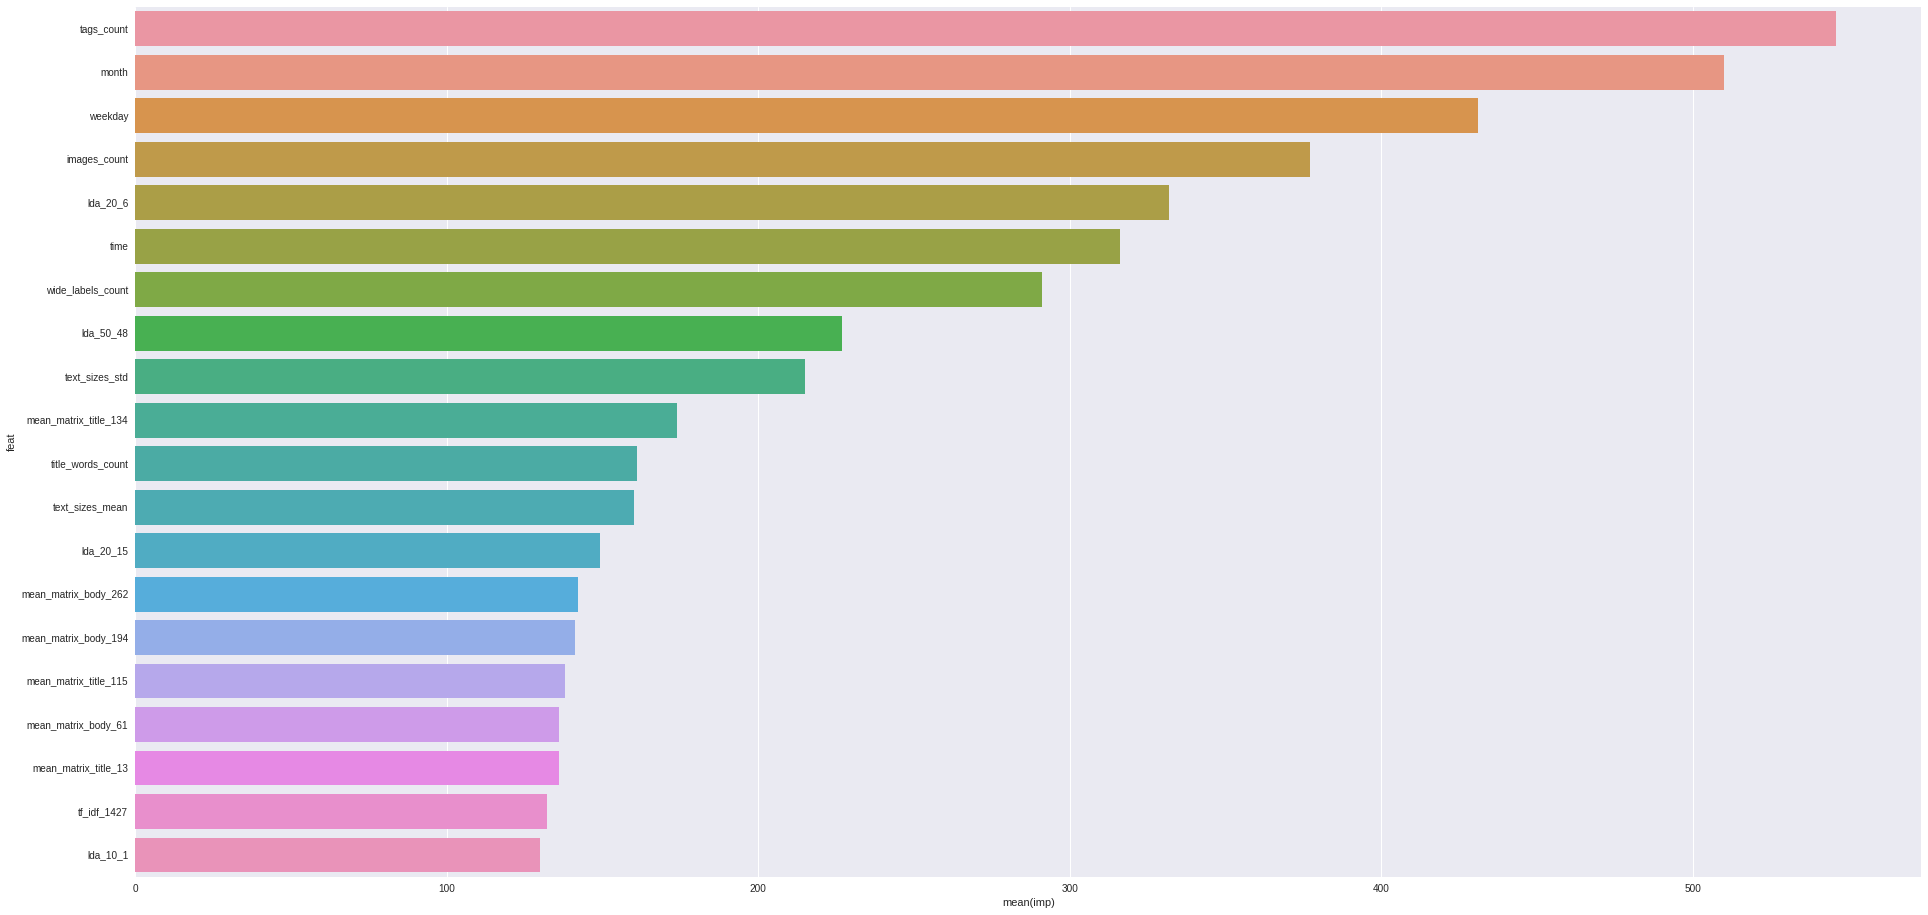

In [68]:
plt.figure(figsize=(32, 16))
importance_table = pd.DataFrame([{"imp": imp, "feat": feat} for feat, imp in importance])
sns.barplot(x="imp", y="feat", data=importance_table.iloc[:20])